# PlagiarismDetection
---

Plagiarism detection tool designed to analyze source code files. [Supporting Java Language]


**Authors**
* José Armando Rosas Balderas | A01704132
* Ramona Najera Fuentes       | A01423596
* Ian Joab Padron Corona      | A01708940

## Libraries

In [1]:
'''
AST Parser
--------------------------------------------------------------------------------------------------
This file contains the code to parse the AST of a given code snippet using tree-sitter.

Authors
--------------------------------------------------------------------------------------------------
  * José Armando Rosas Balderas | A01704132
  * Ramona Najera Fuentes       | A01423596
  * Ian Joab Padron Corona      | A01708940

**Date:** 2025-Apr-28

Libraries
--------------------------------------------------------------------------------------------------
`tree-stitter`: Library for parsing source code into an AST.
`numpy`: Library for numerical computations in Python.
`matplotlib`: Library for creating static, animated, and interactive visualizations in Python.
`sys`: Library for system-specific parameters and functions.
`networkx`: Library for creating and manipulating complex networks.
`warnings`: Library for issuing warning messages.


Usage
--------------------------------------------------------------------------------------------------
This script is used to parse the AST of a given code snippet using tree-sitter.
```
python AST.py <lang_grammar> <path_grammar> <file>
```
'''
from tree_sitter import Language, Parser
import numpy as np
import matplotlib.pyplot as plt
import sys
import networkx as nx
import warnings


# Ignore all warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
def dfs_ast(node, level=0, node_list=None):
  """
  Perform a depth-first search (DFS) on the AST and store the nodes in a list. 
  Preorder traversal is used to visit the nodes.

  Parameters
  ---
  node: `Tree Sitter Node` The current node in the AST.

  level: `int` The current level in the tree. Default is 0.

  node_list: `list` The list to store the nodes. Default is None.

  Returns
  ---
  node_list: `list` The list of nodes in the AST.
  """
  
  if node_list is None:
      node_list = []
  
  node_list.append((node.type, level))

  # Recursively process child nodes
  for child in node.children:
      dfs_ast(child, level + 1, node_list)
  
  return node_list

In [3]:
def hierarchy_pos(cfgGraph, root, width=15., vert_gap=0.5, vert_loc=0, xcenter=0.5):
    """
    Position nodes in a hierarchy layout with increased spacing between nodes at the same level.

    Parameters
    ---
    cfgGraph: `Graph` The graph to be laid out.
    root: `Node` The root node of the hierarchy.
    width: `float` The width of the layout. Default is 2.0 for more spacing.
    vert_gap: `float` The vertical gap between nodes.
    vert_loc: `float` The vertical location of the root node.
    xcenter: `float` The horizontal center of the layout.

    Returns
    ---
    pos: `dict` A dictionary mapping nodes to their positions in the layout.
    """
    def _hierarchy_pos(cfgGraph, root, leftmost, width, vert_gap, vert_loc, xcenter, pos, parent=None):
        children = list(cfgGraph.successors(root))

        if not children:
            pos[root] = (leftmost[0], vert_loc)
            leftmost[0] += width
        else:
            for child in children:
                pos = _hierarchy_pos(cfgGraph, child, leftmost, width, vert_gap, vert_loc - vert_gap, xcenter, pos, root)
            mid = (pos[children[0]][0] + pos[children[-1]][0]) / 2
            pos[root] = (mid, vert_loc)

        return pos

    return _hierarchy_pos(cfgGraph, root, [0], width, vert_gap, vert_loc, xcenter, {})

In [4]:
def AST_toGraph(graph, node, parent=None, counter=[0]):
    """
    Recursively build a graph from a Tree-sitter node

    Parameters
    ---
    
    graph: `Graph` The graph to be built.
    
    node: `Tree Sitter Node` The current node in the AST.
    
    parent: `Node` The parent node of the current node. Default is None.
    
    counter: `list` A list to keep track of the node index. Default is [0].
    
    Returns
    ---
    graph: `Graph` The graph built from the Tree-sitter node.
    """
    
    idx = counter[0]
    label = node.type
    
    if node.child_count == 0:
        label += f": {node.text.decode('utf8')}"
    graph.add_node(idx, label=label)

    if parent is not None:
        graph.add_edge(parent, idx)

    counter[0] += 1
    
    for child in node.children:
        AST_toGraph(graph, child, idx, counter)

    return graph

In [5]:
def printTreeNodes(nodes_list):
    """
    Print the nodes of the AST in a readable format with tabulations to represent the tree structure.

    Parameters
    ---
    nodes_list: `list` The list of nodes in the AST.
    """
    for node_type, level in nodes_list:
        print(f"{'· ' * level}{node_type}")


In [6]:
class CFGBuilder:
    """
    Class to build a Control Flow Graph (CFG) from a given code snippet using tree-sitter.

    Parameters
    ---
    code: `bytes` The code snippet to be parsed.
    """
    def __init__(self, code: bytes):
        self.graph = nx.DiGraph()
        self.counter = 0
        self.code = code
        self.loop_stack = []  # Holds tuples for break/continue statements


    # Generate a detailed label by traversing the node's children
    def generate_label(self, node):
        if node.type == "expression_statement":
            return node.type
        if node.type == "parenthesized_expression":
            # Use only the labels of the child nodes
            return ''.join(self.generate_label(child) for child in node.children)
        if node.child_count == 0:  # Leaf node
            return node.type
        else:  # Non-leaf node
            return ''.join(self.generate_label(child) for child in node.children)

    def get_text(self, node):
        """
        Get the text of a node in the AST.
        
        Parameters
        ---
        node: `Tree Sitter Node` The node to get the text from.
        
        Returns
        ---
        text: `str` The text of the node.
        """
        line = self.code[node.start_byte:node.end_byte].decode("utf-8")
        return line 

    def new_node(self, node, label:str):
        """
        Create a new node in the graph with a unique index and label.

        Parameters
        ---
        label: `str` The label for the new node.
        
        Returns
        ---
        idx: `int` The index of the new node.
        """
        idx = self.counter
        # label = self.generate_label(node)
        # # label = node.type
        # #  # Append additional text for leaf nodes
        # # if node.child_count == 0 and node.text:
        # #     label += f": {node.text.decode('utf8')}"
        self.graph.add_node(idx, label=label)
        self.counter += 1
        return idx

    def connect_all(self, from_nodes, to_node):
        """
        Connect all nodes `from_nodes` -> `to_node`.
        
        Parameters
        ---
        from_nodes: `list` The list of nodes to connect from.
        
        to_node: `int` The node to connect to.
        """
        for n in from_nodes:
            self.graph.add_edge(n, to_node)

    def build_from_ast(self, node):
        """
        Build the CFG from the AST node.
        
        Parameters
        ---
        node: `Tree Sitter Node` The root node of the AST.
        """
        return self._visit(node)

    def _visit(self, node):
        """
        Visit a node in the AST and build the CFG.
        
        Parameters
        ---
        node: `Tree Sitter Node` The node to visit.
        
        Returns
        ---
        entry: `int` The entry node of the CFG.
        
        exit: `list` The exit nodes of the CFG.
        """
        if node.type == "block":
            prev_exit = []
            entry = None
            for child in node.children:
                if child.is_named:
                    subgraph = self._visit(child)
                    if entry is None:
                        entry = subgraph["entry"]
                    if prev_exit:
                        self.connect_all(prev_exit, subgraph["entry"])
                    prev_exit = subgraph["exit"]
            return {"entry": entry, "exit": prev_exit}

        elif node.type == "if_statement":
            cond_node = self.new_node(node, f"if {self.get_text(node.child_by_field_name('condition'))}")
            then_branch = self._visit(node.child_by_field_name("consequence"))
            else_node = node.child_by_field_name("alternative")
            if else_node:
                else_branch = self._visit(else_node)
                self.graph.add_edge(cond_node, then_branch["entry"])
                self.graph.add_edge(cond_node, else_branch["entry"])
                exits = then_branch["exit"] + else_branch["exit"]
            else:
                self.graph.add_edge(cond_node, then_branch["entry"])
                exits = then_branch["exit"] + [cond_node]
            return {"entry": cond_node, "exit": exits}

        elif node.type == "while_statement":
            cond_node = self.new_node(node, f"while {self.get_text(node.child_by_field_name('condition'))}")
            
            self.loop_stack.append((cond_node, []))  # Track exits for break
            
            body = self._visit(node.child_by_field_name("body"))
            self.graph.add_edge(cond_node, body["entry"])
            self.connect_all(body["exit"], cond_node)
            
            _, break_exits = self.loop_stack.pop() # Track exits for break
            
            return {"entry": cond_node, "exit": break_exits + [cond_node]}
        
        elif node.type == "do_statement":
            body_node = node.child_by_field_name("body")
            cond_node = self.new_node(node, f"while {self.get_text(node.child_by_field_name('condition'))}")

            self.loop_stack.append((cond_node, []))

            body = self._visit(body_node)

            self.connect_all(body["exit"], cond_node)  # Body to condition
            self.graph.add_edge(cond_node, body["entry"])  # Loop back if condition true

            _, break_exits = self.loop_stack.pop()
            return {"entry": body["entry"], "exit": break_exits + [cond_node]}

        elif node.type == "for_statement":
            init = self.new_node(node, self.get_text(node.child_by_field_name("init")))
            cond = self.new_node(node, f"for {self.get_text(node.child_by_field_name('condition'))}")
            update = self.new_node(node, self.get_text(node.child_by_field_name("update")))

            self.loop_stack.append((cond, []))  # Track exits for break

            body = self._visit(node.child_by_field_name("body"))

            self.graph.add_edge(init, cond)
            self.graph.add_edge(cond, body["entry"])
            self.connect_all(body["exit"], update)
            self.graph.add_edge(update, cond)

            _, break_exits = self.loop_stack.pop() # Track exits for break
            
            return {"entry": init, "exit": break_exits + [cond]}
        
        elif node.type == "switch_statement":
            cond_node = self.new_node(node, f"switch {self.get_text(node.child_by_field_name('condition'))}")
            body = node.child_by_field_name("body")  # should be a block
            case_entries = []
            last_exits = []

            for child in body.children:
                if child.type in {"switch_label", "case", "default"}:
                    label = self.new_node(child, self.get_text(child))
                    self.graph.add_edge(cond_node, label)
                    case_entries.append(label)
                    last_label = label
                    last_exits = [label]
                elif child.is_named:
                    subgraph = self._visit(child)
                    self.connect_all(last_exits, subgraph["entry"])
                    last_exits = subgraph["exit"]

            return {"entry": cond_node, "exit": last_exits}

        elif node.type == "try_statement":
            try_block = self._visit(node.child_by_field_name("block"))
            exits = try_block["exit"]

            # Handle catch clauses
            catch_clauses = [c for c in node.children if c.type == "catch_clause"]
            for catch in catch_clauses:
                catch_block = self._visit(catch.child_by_field_name("block"))
                self.connect_all([try_block["entry"]], catch_block["entry"])
                exits += catch_block["exit"]

            # Handle finally
            finally_block = node.child_by_field_name("finally_clause")
            if finally_block:
                final_graph = self._visit(finally_block.child_by_field_name("block"))
                self.connect_all(exits, final_graph["entry"])
                exits = final_graph["exit"]

            return {"entry": try_block["entry"], "exit": exits}
        
        elif node.type == "break_statement":
            brk = self.new_node("break")
            if self.loop_stack:
                _, break_targets = self.loop_stack[-1]
                break_targets.append(brk)
            return {"entry": brk, "exit": []}

        elif node.type == "continue_statement":
            cont = self.new_node("continue")
            if self.loop_stack:
                loop_cond, _ = self.loop_stack[-1]
                self.graph.add_edge(cont, loop_cond)
            return {"entry": cont, "exit": []}


        elif node.type == "return_statement":
            ret = self.new_node(node, self.get_text(node))
            return {"entry": ret, "exit": []}

        else:
            stmt = self.new_node(node, self.get_text(node))
            return {"entry": stmt, "exit": [stmt]}


In [7]:
def find_method_declaration(node):
    """
    Recursively search for the first 'method_declaration' node in the AST.

    Parameters:
    ---
    node: `Tree Sitter Node` The current node in the AST.

    Returns:
    ---
    method_node: `Tree Sitter Node` The 'method_declaration' node if found, else None.
    """
    if node.type == "method_declaration":
        return node

    for child in node.children:
        result = find_method_declaration(child)
        if result:
            return result

    return None

In [8]:
def set_parser_grammar(parser, lang_grammar, path_grammar):
    """
    Set the language grammar for the parser.

    Parameters:
    ---
    parser: Parser
        The Tree-sitter parser instance.

    lang_grammar: str
        The programming language grammar ('cpp' or 'java').

    path_grammar: str
        The path to the compiled grammar file.

    Returns:
    ---
    None
    """
    try:
        parser.set_language(Language(path_grammar, lang_grammar))
    except Exception as e:
        print(f"[ERROR]: Failed to load {lang_grammar} language grammar. {e}")
        sys.exit(1)

## File Opening

In [9]:
# Define the constants for the Parser
lang_grammar = 'java'
path_grammar = f'../domain/entities/grammars/{lang_grammar}.so'

name_file = 'HelloWorld.java'
path_file = f'../../resources/datasets/original/{lang_grammar}/{name_file}'

# Initialize the parser
parser = Parser()

# Set the grammar for the parser
set_parser_grammar(parser, lang_grammar, path_grammar)

In [10]:
# Read codes from the provided file path
with open(path_file, 'rb') as f:
    code = f.read()

# Generate the AST for the provided code snippets
tree = parser.parse(code)


## AST Structure

In [11]:
# Generate the list of nodes using DFS
ast_nodes = dfs_ast(tree.root_node)

# Output.txt
printTreeNodes(ast_nodes)


program
· class_declaration
· · modifiers
· · · public
· · class
· · identifier
· · class_body
· · · {
· · · method_declaration
· · · · modifiers
· · · · · public
· · · · · static
· · · · void_type
· · · · identifier
· · · · formal_parameters
· · · · · (
· · · · · formal_parameter
· · · · · · array_type
· · · · · · · type_identifier
· · · · · · · dimensions
· · · · · · · · [
· · · · · · · · ]
· · · · · · identifier
· · · · · )
· · · · block
· · · · · {
· · · · · local_variable_declaration
· · · · · · integral_type
· · · · · · · int
· · · · · · variable_declarator
· · · · · · · identifier
· · · · · · · =
· · · · · · · decimal_integer_literal
· · · · · · ;
· · · · · if_statement
· · · · · · if
· · · · · · parenthesized_expression
· · · · · · · (
· · · · · · · binary_expression
· · · · · · · · identifier
· · · · · · · · ==
· · · · · · · · decimal_integer_literal
· · · · · · · )
· · · · · · block
· · · · · · · {
· · · · · · · expression_statement
· · · · · · · · method_invocation
· · · · ·

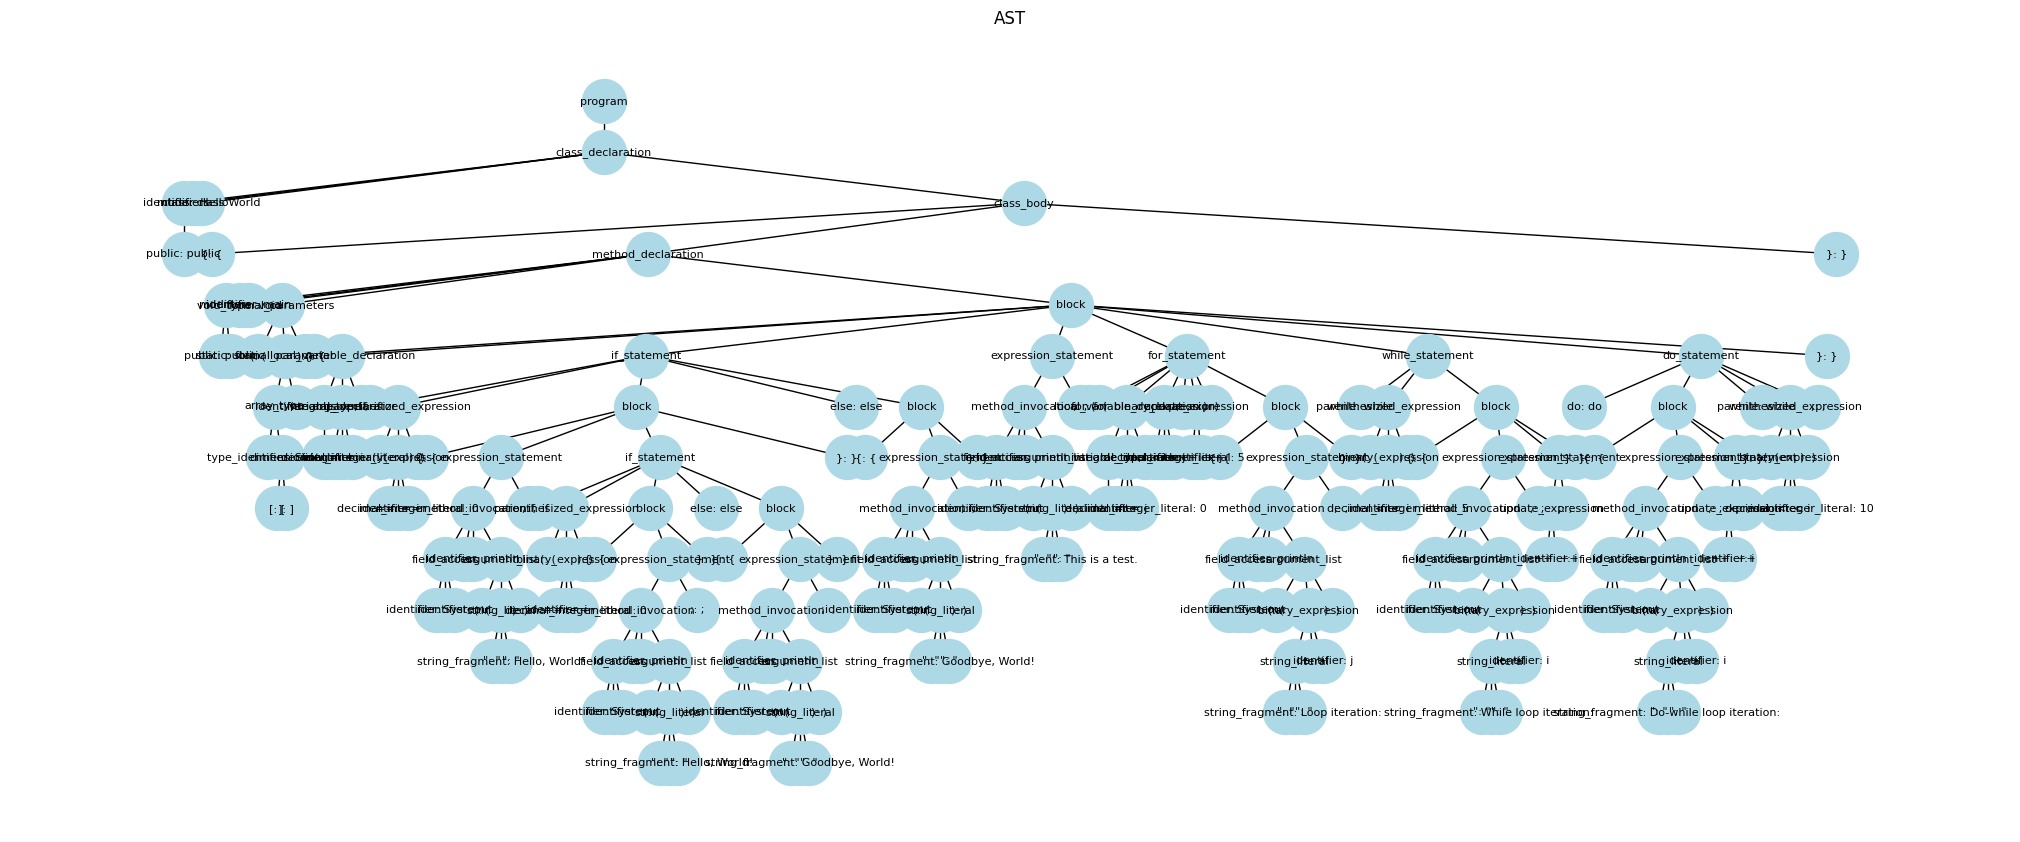

In [12]:
# Build a hyerarchical Tree from the AST
hyerarch_tree = AST_toGraph(nx.DiGraph(), tree.root_node)

# hyerarchical Tree Labels
hyerarch_tree_labels = {n: d['label'] for n, d in hyerarch_tree.nodes(data=True)}

# Draw the graph
hyerarch_tree_labels_pos = hierarchy_pos(hyerarch_tree, root=0)
plt.figure(figsize=(20, 8))

nx.draw(hyerarch_tree, 
        hyerarch_tree_labels_pos, 
        labels=hyerarch_tree_labels, 
        node_color='lightblue', 
        node_size=1000, 
        font_size=8, 
        arrows=False)

plt.title("AST")
plt.show()

## CFG Structure

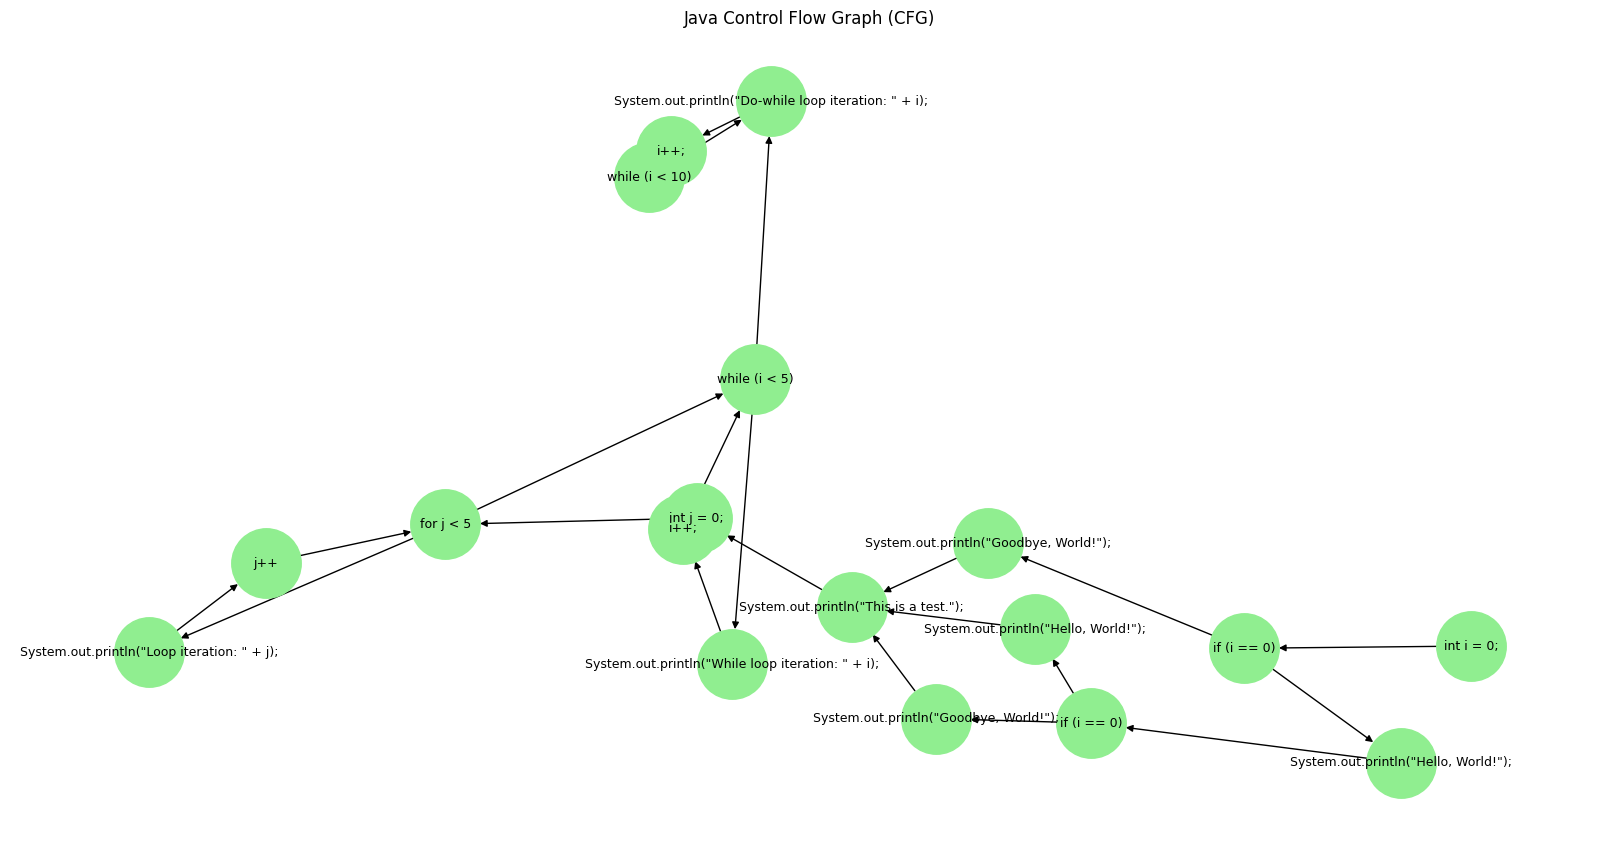

In [13]:
# Find the method declaration node
node_method = find_method_declaration(tree.root_node)

if node_method is None:
    print("[ERROR]: No method_declaration found in the AST.")
    sys.exit(1)

# Build the CFG from the method body
node_body = node_method.child_by_field_name("body")

# Initialize the CFGBuilder
cfg_builder = CFGBuilder(code)
cfg = cfg_builder.build_from_ast(node_body)
cfgGraph = cfg_builder.graph

# Visualization
cfgGraph_pos = nx.spring_layout(cfgGraph)
cfgGraph_labels = nx.get_node_attributes(cfgGraph, 'label')

plt.figure(figsize=(16, 8))
nx.draw(cfgGraph, 
        cfgGraph_pos, 
        with_labels=True, 
        labels=cfgGraph_labels, 
        node_size=2500, 
        node_color='lightgreen', 
        font_size=9, 
        arrows=True)
plt.title("Java Control Flow Graph (CFG)")
plt.show()

## Implementation of Markov Chains

In [14]:
def build_transition_matrix(G):
    """
    Build a transition matrix from the given directed graph.

    Parameters
    ---
    G: `Graph` The directed graph to build the transition matrix from.
    
    Returns
    ---
    matrix: `numpy.ndarray` The transition matrix.
    
    idx_map: `dict` A mapping from node labels to indices in the matrix.
    """
    nodes = list(G.nodes)
    idx_map = {node: i for i, node in enumerate(nodes)}
    size = len(nodes)
    matrix = np.zeros((size, size))

    for src, dst in G.edges():
        i, j = idx_map[src], idx_map[dst]
        matrix[i][j] += 1

    # Normalize rows to get probabilities
    row_sums = matrix.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        matrix = np.divide(matrix, row_sums, where=row_sums != 0)

    return matrix, idx_map

In [15]:
def matrix_similarity(A, B):
    """
    Calculate the similarity between two matrices using the Frobenius norm.

    Parameters
    ---
    A: `numpy.ndarray` The first matrix.
    
    B: `numpy.ndarray` The second matrix.
    
    Returns
    ---
    similarity: `float` The Frobenius norm of the difference between the two matrices.
    """
    # Make sure both matrices are the same shape
    size = max(A.shape[0], B.shape[0])
    A_padded = np.zeros((size, size))
    B_padded = np.zeros((size, size))
    A_padded[:A.shape[0], :A.shape[1]] = A
    B_padded[:B.shape[0], :B.shape[1]] = B

    return np.linalg.norm(A_padded - B_padded)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

def flatten_transition_matrix(G):
    """
    Flatten the transition matrix of the given directed graph.

    Parameters
    ---
    G: `Graph` The directed graph to build the transition matrix from.

    Returns
    ---
    matrix: `numpy.ndarray` The flattened transition matrix.
    """
    # Build the transition matrix
    matrix, _ = build_transition_matrix(G)
    return matrix.flatten()


In [17]:
def cfg_cosine_similarity(cfg1, cfg2):
    """
    Calculate the cosine similarity between two CFGs.

    Parameters
    ---
    cfg1: `Graph` The first CFG.
    
    cfg2: `Graph` The second CFG.
    
    Returns
    ---
    similarity: `float` The cosine similarity between the two CFGs.
    """
    vec1 = flatten_transition_matrix(cfg1).reshape(1, -1)
    vec2 = flatten_transition_matrix(cfg2).reshape(1, -1)

    # Pad to same size if needed
    max_len = max(vec1.shape[1], vec2.shape[1])
    vec1 = np.pad(vec1, ((0, 0), (0, max_len - vec1.shape[1])))
    vec2 = np.pad(vec2, ((0, 0), (0, max_len - vec2.shape[1])))

    return cosine_similarity(vec1, vec2)[0][0]


In [18]:
# Read codes from the provided file path
name_file1 = 'HelloWorld.java'
name_file2 = 'HelloWorld2.java'

path_file1 = f'../../resources/datasets/original/{lang_grammar}/{name_file1}'
path_file2 = f'../../resources/datasets/original/{lang_grammar}/{name_file2}'

with open(path_file1, 'rb') as f1:
    code1 = f1.read()

with open(path_file2, 'rb') as f2:
    code2 = f2.read()

# Generate the AST for the provided code snippets
tree1 = parser.parse(code1)
tree2 = parser.parse(code2)

# Find the method declaration node
node_method1 = find_method_declaration(tree1.root_node)
node_method2 = find_method_declaration(tree2.root_node)

if node_method1 is None or node_method2 is None:
    print("[ERROR]: Method declaration not found in one or both files.")

# Build the CFG from the method body
node_body1 = node_method1.child_by_field_name("body")
node_body2 = node_method2.child_by_field_name("body")

# Initialize the CFGBuilder for both files
cfg_builder1 = CFGBuilder(code1)
cfg1 = cfg_builder1.build_from_ast(node_body1)
cfgGraph1 = cfg_builder1.graph


cfg_builder2 = CFGBuilder(code2)
cfg2 = cfg_builder2.build_from_ast(node_body2)
cfgGraph2 = cfg_builder2.graph

# Build transition matrices for both CFGs
matrix1, _ = build_transition_matrix(cfgGraph1)
matrix2, _ = build_transition_matrix(cfgGraph2)

# Calculate the similarity between the two matrices
simil_m1m2 = cfg_cosine_similarity(cfgGraph1, cfgGraph2)
print(f"Similarity between the two CFGs: {simil_m1m2:.4f}")

Similarity between the two CFGs: 0.1591


## GED (Aproximate)

In [19]:
def compute_approximate_ged(cfg1, cfg2, timeout=15.0):
    """
    Compute the approximate Graph Edit Distance between two CFGs using NetworkX.
    
    Parameters:
        cfg1, cfg2: `networkx.DiGraph`
        Objects representing the control flow graphs
        
        timeout: Maximum time (in seconds) to spend trying to compute the GED
    
    Returns:
        A float representing the approximate GED, or None if it fails.
    """
    try:
        ged = nx.graph_edit_distance(
            cfg1, cfg2, 
            node_match=nx.isomorphism.categorical_node_match('label', default=''),
            edge_match=nx.isomorphism.categorical_edge_match('type', default=''),
            timeout=timeout
        )

        if ged is None:
            return None  # Timeout or no result

        # Estimate max possible GED (very rough upper bound: sum of nodes + edges)
        max_ged = (
            cfg1.number_of_nodes() + cfg2.number_of_nodes() +
            cfg1.number_of_edges() + cfg2.number_of_edges()
        )

        similarity = 1 - (ged / max_ged) if max_ged > 0 else 0.0
        return round(similarity, 4)
    
    except Exception as e:
        print(f"Error during GED computation: {e}")
        return None


In [20]:
ged_score = compute_approximate_ged(cfgGraph1, cfgGraph2)

if ged_score is not None:
    print(f"GED-based similarity: {ged_score:.4f}")
else:
    print("Could not compute similarity (timeout or error).")


GED-based similarity: 0.6479
